In [1]:
# ── Models for Double-NN ────────────────────────────────────────────────────────────

import numpy as np

import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random

import scipy
from scipy import stats
from scipy.stats import beta



mseloss=nn.MSELoss()

def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.2)
            #m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.2)
            #m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.002)
            if m.bias!=None:
              m.bias.data.zero_()

        elif isinstance(m,nn.BatchNorm2d):  # BatchNorm weight init
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)


class EFI_network(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EFI_network, self).__init__()
        # Linear function
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(input_dim,3*hidden_dim)
        self.fc2 = nn.Linear(3*hidden_dim,hidden_dim)
        self.fc_control= nn.Linear(hidden_dim,output_dim)
        self.fc_treat = nn.Linear(hidden_dim,output_dim)
        self.fc_sigma= nn.Linear(hidden_dim,1)

        self.params = nn.ModuleDict({
            'base': nn.ModuleList([self.fc1, self.fc2,self.fc_sigma]),
            'NN': nn.ModuleList([self.fc_treat,self.fc_control])})


    def forward(self, y,x,z,t):
        output1=self.fc1(torch.cat((y,x,z,t),1   ))
        output2=(self.fc2(self.relu(output1)))
        control_estimate=self.fc_control(output2)
        treat_estimate     =self.fc_treat(output2)
        sigma_estimate     =self.fc_sigma(output2)

        return 25*control_estimate, 25*treat_estimate,sigma_estimate

class NN(nn.Module):
    def __init__(self,input_dim,hidden_dim):
        super(NN, self).__init__()
        # Linear function
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,1)


    def forward(self, x):
        output1=self.relu(self.fc1(x))
        output2=self.relu(self.fc2(output1))
        output3=self.fc3(output2)

        return output3

def PEHE(T_true, T_est):
    return np.sqrt(np.mean((T_true.reshape((-1, 1)) - T_est.reshape((-1, 1))) ** 2))


In [3]:
# ── Reproducibility ────────────────────────────────────────────────────────────
np.random.seed(2000)
torch.manual_seed(2000)

# ── Hyperparameters ────────────────────────────────────────────────────────────
p       = 5         # total number of covariates (incl. intercept)
n_train = 1000      # training set size per simulation
n_test  = 1000      # test set size per simulation
S       = 100       # number of simulated datasets

# ── Treatment assign model ────────────────────────────────────────────────────────-
propensity_score_model=beta(2,4)

# ── Pre-allocate data holders ───────────────────────────────────────────────────
X_train_dataset=torch.rand(S,n_train,p-1)
X_test_dataset=torch.rand(S,n_test,p-1)

Z_train_dataset=torch.randn(S,n_train)
Z_test_dataset_T=torch.randn(S,n_test)
Z_test_dataset_C=torch.randn(S,n_test)

T_train_probset=torch.randn(S,n_train)
T_test_probset=torch.randn(S,n_test)

T_train_set=torch.randn(S,n_train)
T_test_set=torch.randn(S,n_test)


# ── Control/Treatment response functions ─────────────────────────────────────────────────

def control(x):
    """Baseline control function: 2*x1 / (1 + 5*x2^2)."""
    return 2 * x[:, 1] / (1 + 5 * x[:, 2]**2)


def treat_effect(x):
    """Treatment effect: 2 * sigmoid(12*(x1 - .5)) * sigmoid(12*(x2 - .5))."""
    s1 = torch.sigmoid(12 * (x[:, 1] - 0.5))
    s2 = torch.sigmoid(12 * (x[:, 2] - 0.5))
    return 2 * s1 * s2

# ── Simulation loop ────────────────────────────────────────────────────────────
for s in range(S):
    # 1) Compute propensity‐score probabilities
    ps_train = propensity_score_model.cdf(X_train_dataset[s,: ,0].cpu().numpy())
    ps_test  = propensity_score_model.cdf(X_test_dataset[s, :, 0].cpu().numpy())

    T_train_probset[s] = torch.from_numpy((1 + ps_train) / 4)
    T_test_probset[s]  = torch.from_numpy((1 + ps_test)  / 4)

    # 2) Sample binary treatments
    T_train_set[s] = torch.bernoulli(T_train_probset[s]).to(dtype=torch.int64)
    T_test_set[s]  = torch.bernoulli(T_test_probset[s]).to(dtype=torch.int64)


[simulation 1/1] epoch    0 — E_loss: 28706.7871


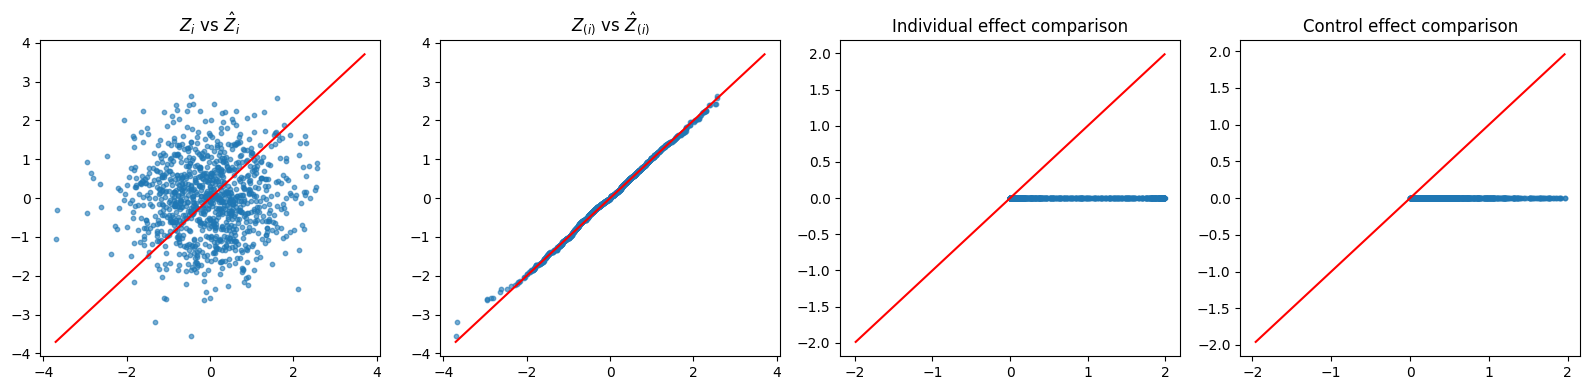

[simulation 1/1] epoch 2000 — E_loss: 495.6779


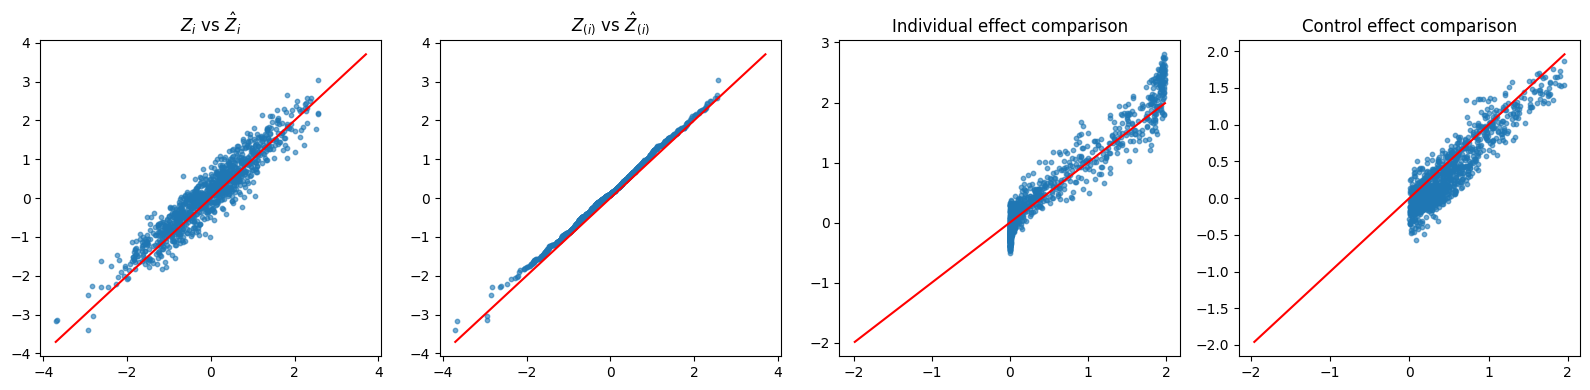

[simulation 1/1] epoch 4000 — E_loss: 492.2281


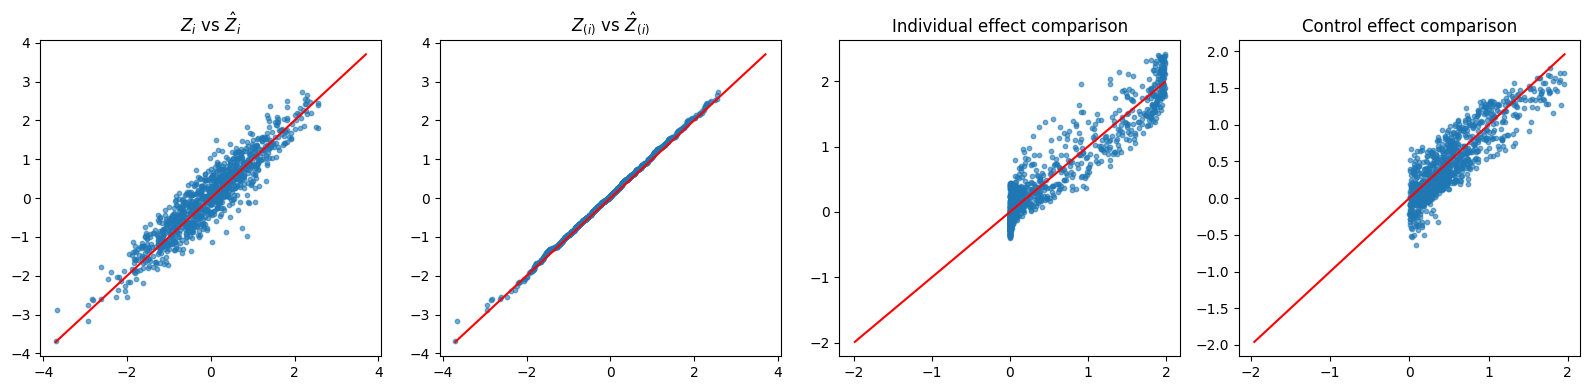

[simulation 1/1] epoch 6000 — E_loss: 510.2557


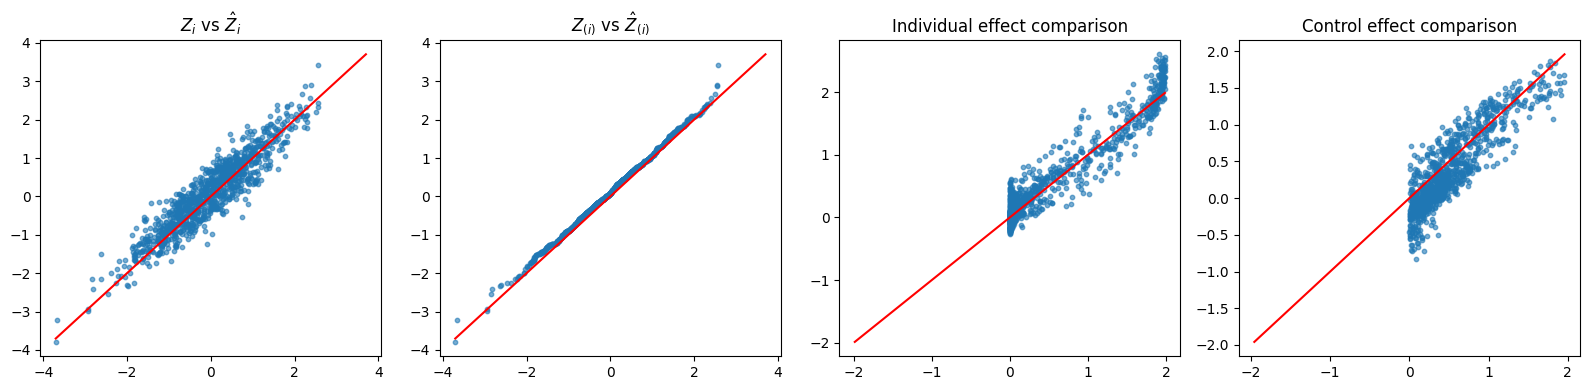

[simulation 1/1] epoch 8000 — E_loss: 445.5050


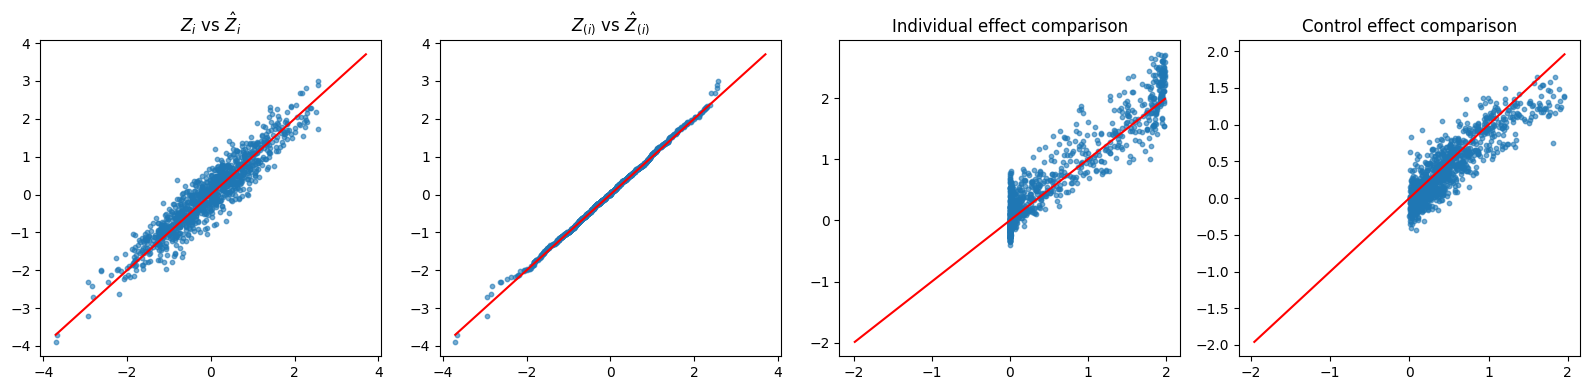

[simulation 1/1] epoch 10000 — E_loss: 475.0602


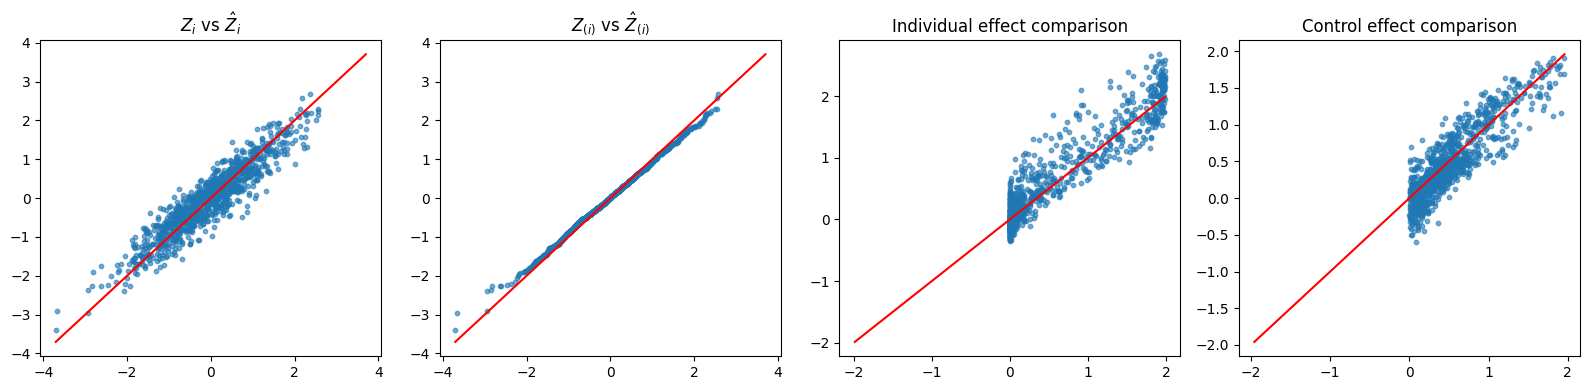

[simulation 1/1] epoch 12000 — E_loss: 505.5456


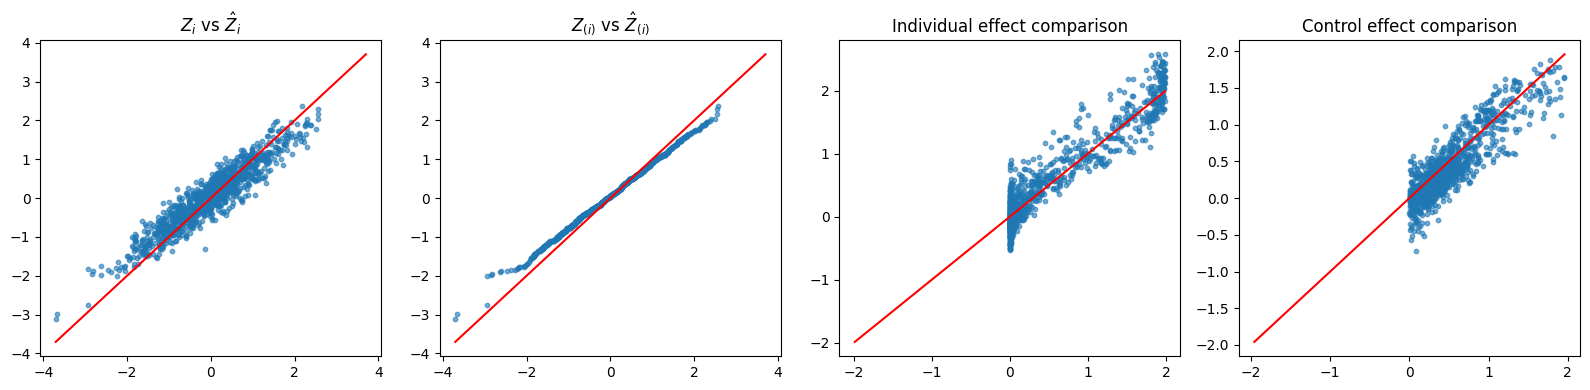

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── Hyperparameters ────────────────────────────────────────────────────────────
hidden_dim    = 10
lambda_1      = 100
lambda_2      = 10

batch_frac    = 5            # subsample factor
subsample_size=int(n_train/batch_frac )
batch_size=int(n_train/subsample_size)
K=int(20000/batch_size)  ## Burn-in period
M=int(50000/batch_size)
alpha         = 0.1      ## SGHMC momentum

# ── Sparse DNN ───────────────────────────────────────────────────────
l=1e-2
sigma_0=np.sqrt(1e-2)
sigma_1=np.sqrt(1)
c1=np.log(l)-np.log(1-l)+1/2*np.log(sigma_0**2)-1/2*np.log(sigma_1**2)
c2=1/2/sigma_0**2-1/2/sigma_1**2
threshold=np.sqrt(np.log( (1-l)/l *sigma_1/sigma_0 )/(1/(2*sigma_0**2)-1/(2*sigma_1**2)))


# ── Helper Functions ───────────────────────────────────────────────────────────

def forward_three_layer_net(X, flat_params, num_list, size_list, activation_fn):
    # First layer: extract weights and biases
    w1 = flat_params[:num_list[0]].view(size_list[0])
    b1 = flat_params[num_list[0]:num_list[1]].view(size_list[1])
    o1 = activation_fn(F.linear(X, w1, b1))

    # Second layer
    w2 = flat_params[num_list[1]:num_list[2]].view(size_list[2])
    b2 = flat_params[num_list[2]:num_list[3]].view(size_list[3])
    o2 = activation_fn(F.linear(o1, w2, b2))

    # Third layer (no activation applied)
    w3 = flat_params[num_list[3]:num_list[4]].view(size_list[4])
    b3 = flat_params[num_list[4]:num_list[5]].view(size_list[5])
    o3 = F.linear(o2, w3, b3)

    return o3

def update_fc_layers(model, flat_params, num_list, size_list):
    # Update fc1
    model.fc1.weight.data = flat_params[:num_list[0]].view(size_list[0]).clone().detach().cpu().cuda()
    model.fc1.bias.data   = flat_params[num_list[0]:num_list[1]].view(size_list[1]).clone().detach().cpu().cuda()

    # Update fc2
    model.fc2.weight.data = flat_params[num_list[1]:num_list[2]].view(size_list[2]).clone().detach().cpu().cuda()
    model.fc2.bias.data   = flat_params[num_list[2]:num_list[3]].view(size_list[3]).clone().detach().cpu().cuda()

    # Update fc3
    model.fc3.weight.data = flat_params[num_list[3]:num_list[4]].view(size_list[4]).clone().detach().cpu().cuda()
    model.fc3.bias.data   = flat_params[num_list[4]:num_list[5]].view(size_list[5]).clone().detach().cpu().cuda()


def plot_identity_comparison(ax, x, y, title=None):
    """
    Scatter y vs. x with a red identity line.
    """
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    # identity line
    m, M = x.min(), x.max()
    MM=max(abs(m),abs(M))
    line = np.linspace(-MM, MM, 100)
    ax.plot(line, line, 'r')
    ax.scatter(x, y, s=10, alpha=0.6)
    if title:
        ax.set_title(title)


def plot_sorted_comparison(ax, x, y, title=None):
    """
    Scatter the sorted values of y vs. the sorted values of x, plus identity.
    """
    x = np.sort(np.asarray(x).ravel())
    y = np.sort(np.asarray(y).ravel())
    m, M = x.min(), x.max()
    MM=max(abs(m),abs(M))

    line = np.linspace(-MM, MM, 100)
    ax.plot(line, line, 'r')
    ax.scatter(x, y, s=10, alpha=0.6)
    if title:
        ax.set_title(title)

# ── Main Simulation ────────────────────────────────────────────────────────────

check_S=1

for s in range(check_S):
    # 1) Initialize models & optimizer
    net_treat   = NN(p, hidden_dim).to(device)
    net_control = NN(p, hidden_dim).to(device)

    N_size_list=[]
    N_number_list=[]

    N_par=0
    for par in net_treat.parameters():
      N_par+=np.prod(np.prod(par.size()))
      N_size_list.append(par.size())
      N_number_list.append(np.prod(par.size()))
    N_number_list=np.cumsum(N_number_list)

    encoder     = EFI_network(p+3, 30, N_par).to(device)
    encoder.apply(initialize_weights)

    optimizer_E = optim.SGD(
        [{'params': encoder.params.base.parameters()},
         {'params': encoder.params.NN.parameters(), 'lr': 0.01/n_train}],
        lr=0.01/n_train
    )

    # 2) Build data for this run
    X_train = torch.cat((torch.ones(n_train,1), X_train_dataset[s]), dim=1).to(device)
    X_test  = torch.cat((torch.ones(n_test,1),  X_test_dataset[s]),  dim=1).to(device)
    Z_train = Z_train_dataset[s].view(n_train,1).to(device)
    Z_testT = Z_test_dataset_T[s].view(n_test,1).to(device)
    Z_testC = Z_test_dataset_C[s].view(n_test,1).to(device)
    T_prob_train = T_train_probset[s].view(n_train,1).to(device)
    T_prob_test  = T_test_probset[s].view(n_test,1).to(device)
    T_train_bin  = T_train_set[s].view(n_train,1).float().to(device)

    y_train = control(X_train).view(n_train,1)+treat_effect(X_train).view(n_train,1)*T_train_bin+Z_train


    ite_train =treat_effect(X_train).view(n_train,1)
    ite_test  =treat_effect(X_test).view(n_test,1)

    control_train =control(X_train).view(n_train,1)
    control_test  =control(X_test).view(n_test,1)


    # 3) Training loop

    Z_o=(1*torch.randn(n_train,1)).cuda().requires_grad_()
    momentum_Z_o=torch.zeros(Z_o.size()).cuda()

    act_f=nn.ReLU()
    iter=0
    for epoch in range(K+M):
        perm = np.random.permutation(n_train)

        idx=list(range(n_train))

        lr_g= 500000/(1000000+(iter+1)**(1/7))/n_train
        if iter<5000:
          Z_o=(1*torch.randn(n_train,1)).cuda().requires_grad_()
          momentum_Z_o=torch.zeros(Z_o.size()).cuda()

        # --- 3.1) Sample Z latent with SGHMC update ---
        thetas = encoder(y_train[idx], X_train[idx], Z_o[idx], 2*T_train_bin[idx]-1)
        bar_NN1 = thetas[0].mean(0); bar_NN2 = thetas[1].mean(0); bar_sigma = torch.exp(thetas[2]).mean(0)

        o_control = forward_three_layer_net(X_train[idx], bar_NN1, N_number_list, N_size_list, act_f)
        o_treatment = forward_three_layer_net(X_train[idx], bar_NN2, N_number_list, N_size_list, act_f)


        tilde_y = o_control + o_treatment*T_train_bin[idx] + bar_sigma*Z_o[idx]

        Z_loss=lambda_2*n_train*mseloss(y_train[idx],tilde_y)
        Z_loss+=n_train*torch.mean(Z_o[idx]**2)/2
        Z_loss+=50000*torch.relu(torch.mean(Z_o[idx]**2)-1) ## (Manifold constraint)
        Z_loss+=lambda_1*n_train*torch.mean(((bar_sigma)-torch.exp(thetas[2]) )**2)+lambda_1*n_train*torch.mean((bar_NN1-thetas[0] )**2)+ lambda_1*n_train*torch.mean((bar_NN2-thetas[1] )**2)

        if Z_o.grad is not None:
          Z_o.grad.zero_()
          optimizer_E.zero_grad()
        Z_loss.backward()

        momentum_Z_o *=(1-alpha)
        momentum_Z_o += -lr_g * Z_o.grad+ torch.FloatTensor(Z_o.shape).cuda().normal_().mul(np.sqrt(2*alpha*lr_g))
        Z_o.data += momentum_Z_o

        for b in range(batch_size):
            idx=perm[b*subsample_size:b*subsample_size+subsample_size]

            # --- 3.2) Update encoder weights ---
            base_group, nn_group = optimizer_E.param_groups
            base_group['lr'] = 5000/(1000000+(iter+1)**(1/7))/n_train
            nn_group  ['lr'] = 2.5/(1000000+(iter+1)**(1/7))/n_train

            thetas = encoder(y_train[idx], X_train[idx], Z_o[idx], 2*T_train_bin[idx]-1)
            bar_NN1 = thetas[0].mean(0); bar_NN2 = thetas[1].mean(0); bar_sigma = torch.exp(thetas[2]).mean(0)

            o_control = forward_three_layer_net(X_train[idx], bar_NN1, N_number_list, N_size_list, act_f)
            o_treatment = forward_three_layer_net(X_train[idx], bar_NN2, N_number_list, N_size_list, act_f)

            tilde_y = o_control + o_treatment*T_train_bin[idx] + bar_sigma*Z_o[idx]

            E_loss=lambda_2*n_train*mseloss(y_train[idx],tilde_y)
            E_loss+=lambda_1*n_train*torch.mean(((bar_sigma)-torch.exp(thetas[2]) )**2)+ lambda_1*n_train*torch.mean((bar_NN1-thetas[0] )**2)+ lambda_1*n_train*torch.mean((bar_NN2-thetas[1] )**2)

            optimizer_E.zero_grad()

            E_loss.backward()

            with torch.no_grad():
              for param in encoder.parameters():
                temp=1/(torch.exp(c2*torch.mul(param.data,param.data)+c1)+1)
                prior=-torch.mul(param.data,temp)/sigma_0**2-torch.mul(param.data,(1-temp))/sigma_1**2
                param.grad.data -=prior/n_train

            if epoch<100:
              torch.nn.utils.clip_grad_norm_(encoder.parameters(),5000)
            optimizer_E.step()

            iter+=1
        # (Optional) logging every N epochs
        if epoch % 2000 == 0 :
            print(f"[simulation {s+1}/{check_S}] epoch {epoch:4d} — E_loss: {E_loss.item():.4f}")
            thetas=encoder(y_train,X_train,Z_o,2*T_train_bin-1)
            bar_NN1 = torch.mean(thetas[0], dim=0)
            bar_NN2 = torch.mean(thetas[1], dim=0)
            bar_sigma = torch.mean(torch.exp(thetas[2]), dim=0)


            update_fc_layers(net_control , bar_NN1 ,N_number_list, N_size_list)
            update_fc_layers(net_treat , bar_NN2, N_number_list, N_size_list)
            true_Z_np=(Z_train).detach().cpu().numpy()
            Z_np=(Z_o).detach().cpu().numpy()
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))

            # 1. raw Z vs. \hat{Z}
            plot_identity_comparison(
                axes[0],
                true_Z_np,
                Z_np,
                r"$Z_i$ vs $\hat Z_i$"
            )

            # 2. sorted Z vs. sorted \hat{Z}
            plot_sorted_comparison(
                axes[1],
                true_Z_np,
                Z_np,
                r"$Z_{(i)}$ vs $\hat Z_{(i)}$"
            )

            # 3. individual treatment effect
            plot_identity_comparison(
                axes[2],
                ite_train.detach().cpu().numpy(),
                net_treat(X_train).detach().cpu().numpy(),
                "Individual effect comparison"
            )

            # 4. control effect
            plot_identity_comparison(
                axes[3],
                control_train.detach().cpu().numpy(),
                net_control(X_train).detach().cpu().numpy(),
                "Control effect comparison"
            )

            plt.tight_layout()
            plt.show()

        # --- 3.3) Collect c and tau networks for prediction values for statistical inference
        if epoch>K and epoch%5==0:
          thetas=encoder(y_train,X_train,Z_o,2*T_train_bin-1)
          bar_NN1 = torch.mean(thetas[0], dim=0)
          bar_NN2 = torch.mean(thetas[1], dim=0)
          bar_sigma = torch.mean(torch.exp(thetas[2]), dim=0)

          update_fc_layers(net_control , bar_NN1 ,N_number_list, N_size_list)
          update_fc_layers(net_treat , bar_NN2, N_number_list, N_size_list)

          # Collect net_control(X_test), net_treat(X_test), or net_control(X_test)+net_treat(X_test)

